# Optical flow for control
In this notebook, we will study how we can determine ego-motion and structure with the help of optical flow from an image sequence. We assume a pinhole camera in this notebook. We first start with a theoretical derivation of the optical flow formulas (expressing the optical flow in terms of ego-motion and structure of the observed scene). Then we will discuss how structure and ego-motion can be obtained from these formulas. Finally, you can play with a Python script that determines important optical flow observables such as the divergence from an image sequence.

## Deriving the optical flow formula
Each point in an image $(x, y)$ has an associated optical flow $(u, v)$. Here we will derive an expression for the optical flow in terms of the movement of the camera, translational velocities $(U, V, W)$ and rotation rates $(A,B,C)$, and the coordinate of the projected point in the real world, $(X, Y, Z)$. This derivation is based on [2], from which we adopt the notation.

We also use the coordinate system as introduced in [2], which is shown in Figure 1. In the system, O represents the center of the camera, $X$ is positive toward the left, $Y$ positive up, and $Z$ is positive in the direction of the camera’s principal axis.

<CENTER>
<IMG SRC="coordinate_system.png" ALT="Coordinate system used in the optical flow derivation." WIDTH="500"></IMG>
<small>Figure 1: Coordinate system from [2].</small>
</CENTER>

We start with the formulas for the image coordinate of a world point $P$ at $(X, Y, Z)$:

$x = \frac{X}{Z}$ and $y = \frac{Y}{Z}$,

where the reader should note that $x$ and $y$ are _normalized_ image coordinates. The optical flow then is:

$u = \frac{\partial}{\partial t} x = \dot{x}$

and

$v = \frac{\partial}{\partial t} y = \dot{y}$

Here, we first express $\dot{x}$ and $\dot{y}$ in the variables representing the camera movement and $P$'s coordinate:

$\dot{x} = \frac{\dot{X}}{Z} - \frac{X \dot{Z}}{Z^2}$      (Eq. 1),

and

$\dot{y} = \frac{\dot{Y}}{Z} - \frac{Y \dot{Z}}{Z^2}$      (Eq. 2),

which shows that we should find the expressions for $\dot{X}$, $\dot{Y}$ and $\dot{Z}$.

We will determine the time derivative of $x$, as the derivation of $\dot{y}$ is similar. Let us start with $\dot{X}$, which captures the change in coordinate $X$ as measured from the camera's origin over time. Obviously, if the camera has a positive velocity $U$, in its own reference frame the (static) point $P$ will move with the same velocity in the other direction. So:

$\dot{X} = -U + \ldots$

<CENTER>
<IMG SRC="rotation_beta.png" WIDTH="200" ALT="Effect of a rotation around the Y-axis on the X-position of a point P."></IMG>
<small>Figure 2: Rotation around Y -axis, with rotation rate B.</small>
</CENTER>

Furthermore, a rotation around the $Y$-axis ($B$) also has an effect on the change in coordinate $X$. Please look at Figure 2, depicting a point P that is rotated with a rotation rate $B$. First, we can express $X$ and $Z$ in terms of the angle $\beta$ and distance of P to the origin, $R$:

$X = R \mathrm{cos}(\beta)$, and $Z = R \mathrm{sin}(\beta)$.

Then we can determine $\dot{X}$ as:

$\dot{X} = \dot{R} \mathrm{cos}(\beta) - R \mathrm{sin}(\beta) \dot{\beta}$,

where $\dot{R}=0$ for a rotation, and $\dot{\beta} = B$:

$\dot{X} = - R \mathrm{sin}(\beta) B = -B Z$,

where the last equality uses the equality $Z = R \mathrm{sin}(\beta)$. So this brings us to:

$\dot{X} = -U -BZ + \ldots$

A similar reasoning (left as exercise for the student) leads to the addition of $+CY$. The derivations for $\dot{Y}$ are also similar, with as result:

$\dot{X} = -U -BZ + CY$,
$\dot{Y} = -V -CX + AZ$,
$\dot{Z} = -W -AY + BX$.

We can fill in these expressions into Eq. 1 and 2:

$u = \dot{x} = \frac{-U -BZ + CY}{Z} - \frac{X (-W -AY + BX)}{Z^2}$,

which we can write differently as:

$u = \dot{x} = -\frac{U}{Z} - B + Cy + x \frac{W}{Z} + A x y - B x^2$,

where we have used $x = \frac{X}{Z}$ and $y = \frac{Y}{Z}$.

In [2], the optical flow formulas are finally written as follows:

$u = (-\frac{U}{Z} - B + Cy) - x (\frac{W}{Z} - A y + B x)$,

$v = (-\frac{V}{Z} -Cx + A) -y (-\frac{W}{Z} - A y + B x)$.

## Information available from optical flow
The first thing to notice about the optical flow equations is that the flow has a separate translational and rotational component:
$u = -\frac{U}{Z}  - x \frac{W}{Z} - A xy + B x^2 - B + Cy = u_T + u_R$,
$v = -\frac{V}{Z} +y\frac{W}{Z} -Cx + A  + A y^2 - B xy = v_T + v_R$.

Let us for now assume that we know the rotations, for instance by measuring the rotation rates with a gyro, and that we can cancel the rotational component of the optical flow. Then, we are left only with the translational component, which can provide us with interesting information. 

For instance, let's see what the physical meaning of the Focus of Expansion (FoE) is, the point in which the optical flow is zero:

$u_T = 0 = -\frac{U}{Z}  - x_{\mathrm{FoE}} \frac{W}{Z}$
$x_{\mathrm{FoE}} = -\frac{U}{W}$

Similarly:
$v_T = 0 = -\frac{V}{Z} + y_{\mathrm{FoE}} \frac{W}{Z}$
$y_{\mathrm{FoE}} = \frac{V}{W}$

, so that:
$\frac{x_{\mathrm{FoE}}}{y_{\mathrm{FoE}}} = -\frac{U}{V}$

indicates the direction in which the camera is travelling. So, if a robot can find the point where the optical flow is zero, it can find out in what direction it is moving. Also, we can show that all the flow will move away from this point. We first re-express $u_T$, $v_T$ as follows:
$u_T = (-U  - x W) / Z = (-\frac{U}{W} -x) \frac{W}{Z} = -(x - x_{\mathrm{FoE}}) \frac{W}{Z}$
$v_T = (-\frac{V}{W} + y) \frac{W}{Z} = (y - y_{\mathrm{FoE}}) \frac{W}{Z}$
, which means that:
$u_T / v_T = (x - x_{\mathrm{FoE}}) / (y - y_{\mathrm{FoE}})$,
so that the optical flow always points straight away from the FoE. 

<CENTER>
<IMG SRC="focus_of_expansion.png" WIDTH="300" ALT="Translational flow is 0 in the focus of expansion (FoE) and all flow points away from the FoE when moving toward that point."></IMG>
<small>Figure 3: Translational flow is 0 in the focus of expansion (FoE) and all flow points away from the FoE when moving toward that point.</small>
</CENTER>

The equations above also show how to determine the relative velocity in the direction of the camera's principal axis:
$\frac{W}{Z} = \frac{u_T}{(x - x_{\mathrm{FoE}})} = \frac{v_T}{(y - y_{\mathrm{FoE}})}$,
, which is inversely related to the 'time-to-contact' $\frac{Z}{W}$ and the divergence $2\frac{W}{Z}$ (under a flat plane assumption). In the literature on optical flow landing, the 'ventral flow' indicates $\frac{U}{Z}$ (in the $X$-direction) or $\frac{V}{Z}$ (in the $Y$-direction).

##Extracting information from the optical flow field
We are now going to extract information such as the relative velocity from an image sequence. The image sequence has been generated artificially, so that the observer moves straight towards a flat surface. Moreover, the observer is only translating, not rotating. 

<CENTER>
<table>
    <tr>
        <th> <IMG SRC="./image_sequence_pure_ver1/image_1.jpg" WIDTH="100"></IMG> </th>
        <th> <IMG SRC="./image_sequence_pure_ver1/image_30.jpg" WIDTH="100"></IMG> </th>
        <th> <IMG SRC="./image_sequence_pure_ver1/image_60.jpg" WIDTH="100"></IMG> </th>
        <th> <IMG SRC="./image_sequence_pure_ver1/image_99.jpg" WIDTH="100"></IMG> </th>
    </tr>
</table> 
<small>Figure 4: Images from the image sequence (images 1, 30, 60, 99). The observer moves towards the surface in 100 frames.</small>
</CENTER>


Elapsed time = 0.0039904117584228516
error = 0.058074136976423274, FoE = -0.5545806770684426, 1.6212276043583485, and divergence = 0.010427123977681717
Elapsed time = 0.001996278762817383
error = 0.03638225616106573, FoE = -1.043185088036867, -1.2381469791681334, and divergence = 0.01024640853571626
Elapsed time = 0.0030202865600585938
error = 0.04225759156844358, FoE = -0.33397718506746404, -0.638885419259697, and divergence = 0.010400177552168582
Elapsed time = 0.0029876232147216797
error = 0.03809306474848459, FoE = -0.9913014559395927, -1.6220408262174537, and divergence = 0.01045161915647531
Elapsed time = 0.0029730796813964844
error = 0.037139350777768705, FoE = -0.5596111091871235, -1.287341156103146, and divergence = 0.010551759642235984
Elapsed time = 0.001966238021850586
error = 0.03173701828939014, FoE = -1.699185235227881, -0.7257101313313066, and divergence = 0.010677855178009853
Elapsed time = 0.0029883384704589844
error = 0.03455947925343231, FoE = -0.9776015718818758, -

C:\Users\guido\Desktop\optic_flow_notebook\extract_information_flow_field.py:211: RuntimeWarning: invalid value encountered in double_scalars
  FoE[0] = -pu[2]/pu[0]; #0.0;
C:\Users\guido\Desktop\optic_flow_notebook\extract_information_flow_field.py:212: RuntimeWarning: invalid value encountered in double_scalars
  FoE[1] = -pv[2]/pv[1]; #0.0;


error = 10.0, FoE = nan, nan, and divergence = 0.0
Elapsed time = 0.0019941329956054688
error = 10.0, FoE = nan, nan, and divergence = 0.0
Elapsed time = 0.0019931793212890625
error = 10.0, FoE = nan, nan, and divergence = 0.0
*** average elapsed time = 0.0022324372311027683 ***


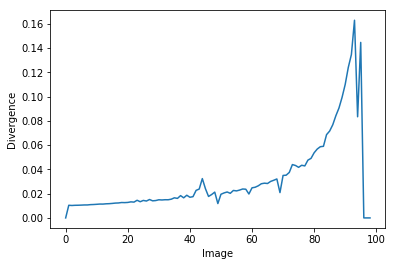

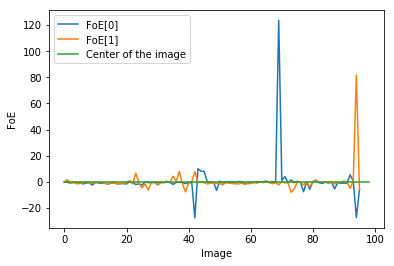

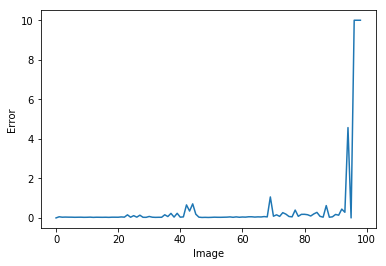

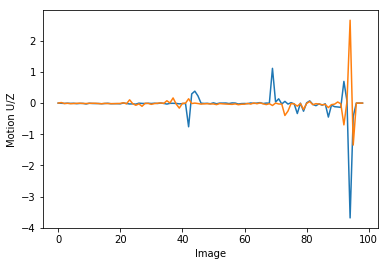

In [4]:
import extract_information_flow_field as OF

OF.extract_flow_information(flow_graphics=False)
